# Covid-19 Impact on Businesses in Bellevue, WA

> Data Analysis project

- toc: true 
- badges: true
- comments: true
- categories: [data analysis]
- image: images/chart-preview.png
- hide: false

## Introduction
It has been more than two years since Covid-19 pandemic started in the U.S. Though our lives are getting back to normal, Covid's impact to our society is significant. A few weeks ago, my wife told me about her observation that it seemed like there were a lot more small businesses poping up near the area where we lived on Google Map, and she speculated that is was mainly due to Covid's influence. So, I decided to prove or disprove this by applying my data analysis skill, and I will walk through how I did it in this post.

## Dataset
Thanks to City of Bellevue | Open Data, I download Business Listing dataset [here](https://data.bellevuewa.gov/datasets/cobgis::business-listing/about) on May 29,2022. It's a tabular data containing information of new business such as names, addresses and start date. There are 41,407 business with start date ranging from 1953 to 2022

In [1]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline


import json
import plotly.express as px
from naics_convert import naics2industries, naics2sectors

In [2]:
#collapse
business = pd.read_csv("data/Business_Listing.csv", low_memory=False)
for date_col in ['CancelDate','FirstActivityDate','IssueDate']:
    business[date_col] = pd.to_datetime(business[date_col])

In [3]:
#collapse
business.shape[0], business['IssueDate'].min(),business['IssueDate'].max()

(41407,
 Timestamp('1953-01-01 08:00:00+0000', tz='UTC'),
 Timestamp('2022-05-26 06:59:59+0000', tz='UTC'))

## Objective
The goal is to determine whether more people are starting their own businesses in Bellevue. It's also interesting if we can get an insight of what these business do.

### Preprocess Data
There are some preprocessing steps we need to do so that we can have not only a clean dataset but additional data not already existed in the original dataset. Here are the first 5 rows:

In [4]:
#collapse
business.head()

X          Y  ObjectId  BusinessFactId  BusinessId  \
0 -122.118803  47.594151         1               1      171474   
1 -122.132494  47.605783         2               2      171612   
2 -122.132017  47.622329         3               3       31781   
3 -122.190504  47.626318         4               4       38947   
4 -122.117462  47.641262         5               5      167692   

                  LegalEntityName                         Dba           Ubi  \
0           ABACUS SCIENTIFIC INC           ABACUS SCIENTIFIC  6.047495e+15   
1  BELLEVUE SUNFLOWER DAYCARE,LLC  BELLEVUE SUNFLOWER DAYCARE  6.047834e+15   
2        BURGERMASTER OF BELLEVUE                         NaN  1.790218e+08   
3       CARL H JELSTRUP DC PS INC                         NaN  6.013319e+08   
4           ICK International Inc       ICK International Inc  6.044245e+15   

       Naic LegalEntityType  ... MailingZip4 PhysicalAddressLine1  \
0  541519.0     Corporation  ...        5150     16517 SE 18th St   
1  611710.0     LLC or PLLC  ...        5345     445 156th Ave SE   
2  722513.0             NaN  ...        5098     1350 156TH AV NE   
3  621310.0     Corporation  ...         NaN     1750 112TH AV NE   
4  541613.0     Corporation  ...        6173     3508 167th Pl NE   

   PhysicalAddressLine2               Textbox4 PhysicalCity PhysicalState  \
0                   NaN      16517 SE 18th St      Bellevue            WA   
1                   NaN      445 156th Ave SE      Bellevue            WA   
2                   NaN      1350 156TH AV NE      BELLEVUE            WA   
3                  D154  1750 112TH AV NE D154     BELLEVUE            WA   
4                   NaN      3508 167th Pl NE      Bellevue            WA   

  PhysicalPostalCode PhysicalZip4  \
0              98008       5150.0   
1              98007       5345.0   
2              98007       4412.0   
3              98005       3727.0   
4              98008       6173.0   

                                 ProductsAndServices                 IssueDate  
0        Research and development. Computer Software 2021-07-26 06:59:59+00:00  
1  Family childcare services for kids under 12-ye... 2021-08-09 06:59:59+00:00  
2                                         RESTAURANT 1988-11-01 07:59:59+00:00  
3                           CHIROPRACTIC HEALTH CARE 1992-04-01 08:00:00+00:00  
4                 SOFTWARE DEVELOPMENT and MARKETING 2020-04-08 06:59:59+00:00  

[5 rows x 28 columns]

Since we are interested in Covid's influence on new businesses, IssueDate (start date) would be critical to help us determine the business started before or after pandemic. We will drop 217 business with missing IssueDate. 

In [5]:
#collapse
print(business['IssueDate'].isna().sum())
business = business.dropna(subset=['IssueDate'])

217


The dataset also has Naic column, which stands for North American Industry Classification, often called NAICS code. This system classifies businesses by their types of economic activity and assign codes to uniquely identify the classification. We can extract sector and industry information from NAICS code for each business, which is extremely helpful for visualizing business trend based on their economic activities. I also package the functions to convert NAICS codes to sectors and industries and upload to PyPI. Here is a sample of result:

In [6]:
#collapse
business["Sector"] = naics2sectors(business["Naic"])
business["Industry"] = naics2industries(business["Naic"])
business['Year'] = business['IssueDate'].dt.year
business[['LegalEntityName','Dba','Sector','Industry']].head(2)

LegalEntityName                         Dba  \
0           ABACUS SCIENTIFIC INC           ABACUS SCIENTIFIC   
1  BELLEVUE SUNFLOWER DAYCARE,LLC  BELLEVUE SUNFLOWER DAYCARE   

                                             Sector  \
0  Professional, Scientific, and Technical Services   
1                              Educational Services   

                          Industry  
0  Other Computer Related Services  
1     Educational Support Services

### Addresses
My initial approach is to classify businesses based on whether the address is residential or commercial by fetching residential delivery indicator(RDI). Unfortunately, it's only feasible with paid API (which I am reluctant to get for a hobby project). But, we can still plot business locations on a map. Mapbox provides free limited API request for its awesome Maps service. In addition, we use lock down date, March 24, 2020, to divid businesses into pre-covid and post-covid, and truncate the dataset to keep only businesses with IssueDate after 2017 to avoid pre-covid business overwhelm post-covid ones in the plots, and the time intervals are very close between pre-covid and post covid, which are both about 2 years and 3 months.

In [7]:
#collapse
business['post_covid'] = (business['IssueDate'] >= '2020-03-24')
business = business[business['Year']>2017]
with open('mapbox_token.json','r') as openfile:
    mapbox_token = json.load(openfile)
px.set_mapbox_access_token(mapbox_token['token'])
fig = px.scatter_mapbox(business,lat='Y',lon='X',color='post_covid',zoom=10,
                        hover_name='LegalEntityName',opacity=0.6,title='Business Listing in Bellevue Pre/Post Covid-19')
fig.show()

Blue dots represent post-covid businesses, and we can see they are more spread out. This may implies post-covid new businesses tend to locate in residential area, but we can't draw a conclusion merely based on the map plot. Let's see if we can find other useful insights from the dataset.

### Sector and Industry
With sector and industry data extracted from NAICS code, we can plot composition of business activities by year and compare them. Let's first plot sectors in pie charts by each year from 2018

In [8]:
#collapse
all_sectors = business['Sector'].value_counts()
labels = all_sectors.index.to_list()
colors = dict(zip(labels,plt.cm.tab20.colors[:len(labels)]))
colors['Other'] = plt.cm.tab20_r.colors[2]
def plot_sector(year):
    plt.figure(figsize=(12,8))
    sector_count = business[business['Year']==year]['Sector'].value_counts()
    sector_count[10] = sum(sector_count[10:])
    sector_count = sector_count[:11]
    sector_index = sector_count.index.to_list()
    sector_index[10] = 'Other'
    sector_count.index = sector_index
    explode = np.zeros(11)
    explode[sector_index.index("Accommodation and Food Services")] = 0.35
    ax = sector_count.plot.pie(autopct='%1.1f%%',explode=explode,wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},colors=[colors[key] for key in sector_count.index],textprops={'fontsize':12})
    plt.title(year)
    plt.ylabel("")
    plt.tight_layout()

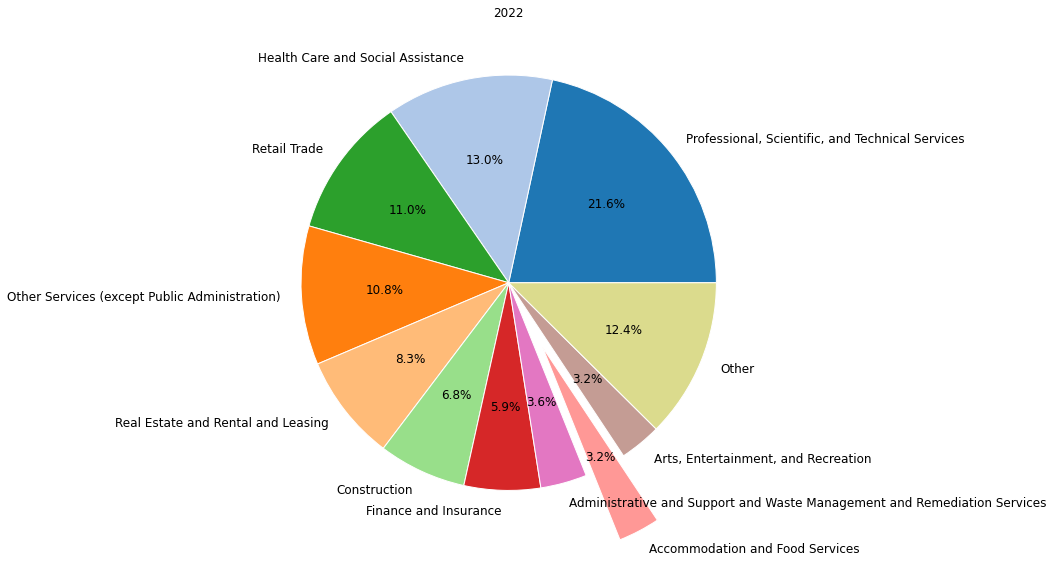

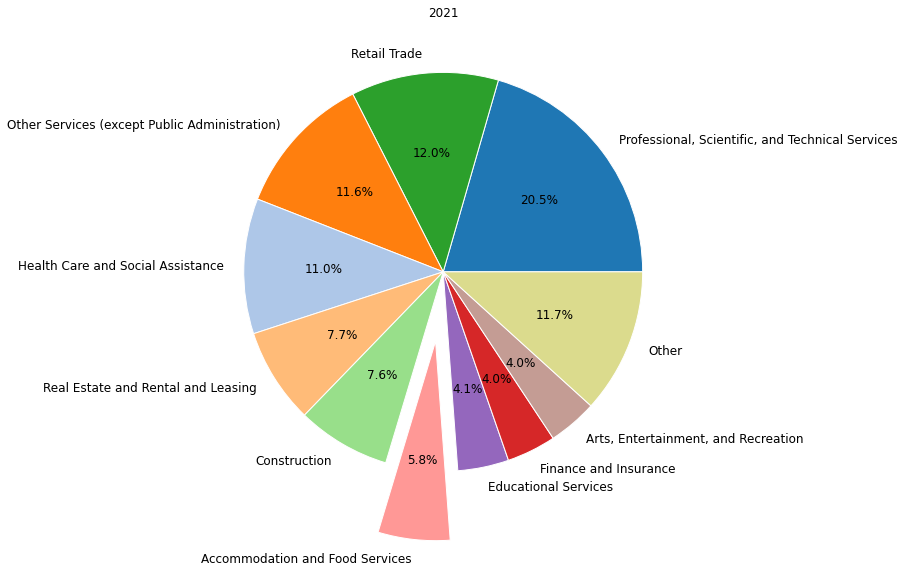

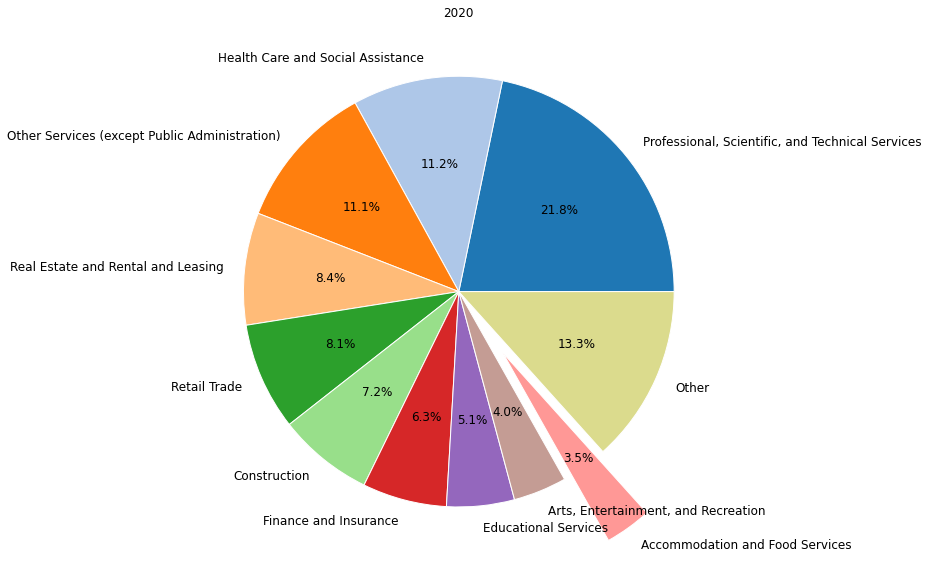

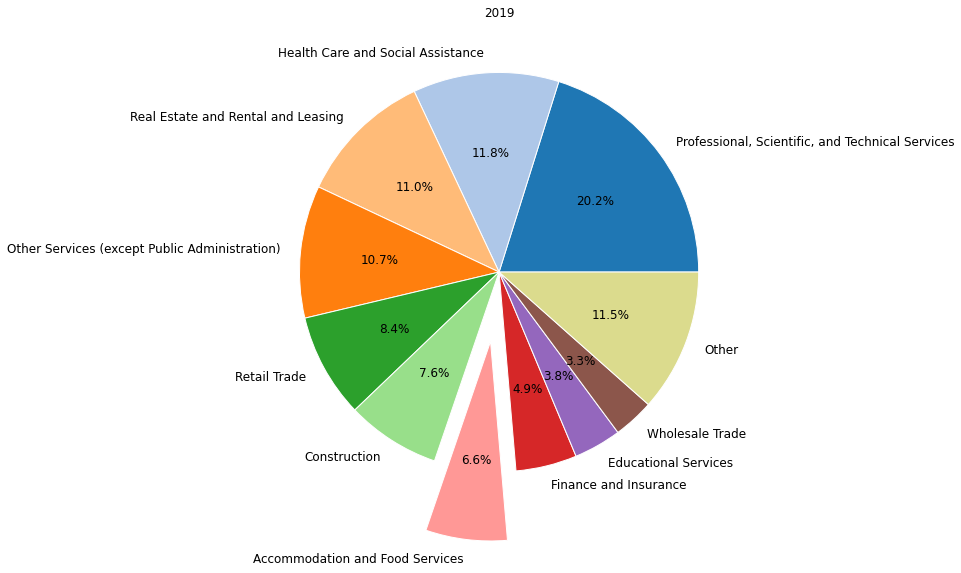

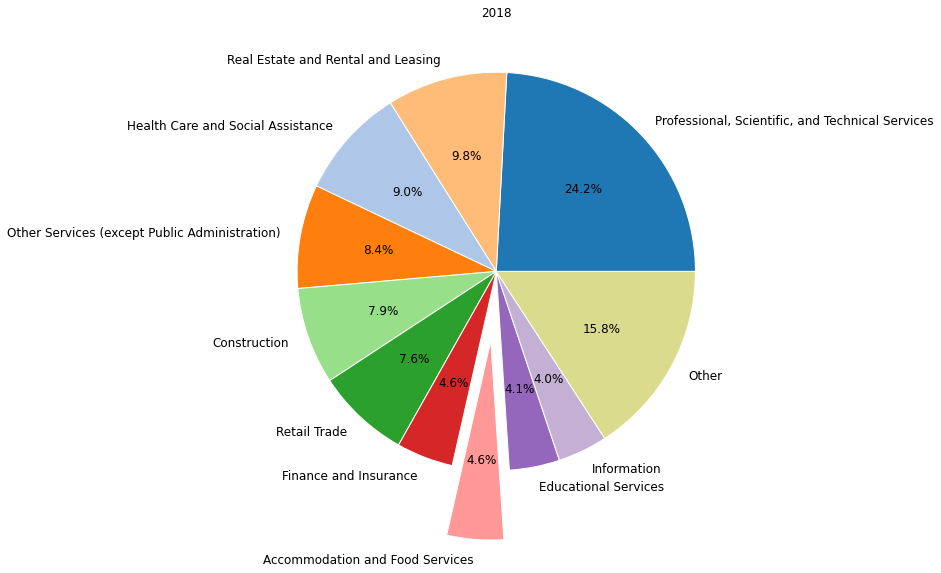

In [9]:
#collapse
for year in sorted(business['Year'].unique(),reverse=True):
    plot_sector(year)
plt.show()

Altough sector distribution doesn't vary much, we can tell *Accommodation and Food Services* shows a slight down trend since 2020, which could be a result of the pandemic. Let's look at industry data.

In [10]:
#collapse
industry_dict = {}
post_covid = set()
pre_covid = set()
for year in sorted(business['Year'].unique(),reverse=True):
    industry_count = business[business['Year']==year]['Industry'].value_counts()
    industry_count = industry_count[:10]
    industry_dict[year] = industry_count.index
    if year < 2020:
        pre_covid.update(industry_count.index)
    else:
        post_covid.update(industry_count.index)
pd.DataFrame(industry_dict)

2022  \
0              Custom Computer Programming Services    
1  Offices of Mental Health Practitioners (except...   
2                                     Beauty Salons    
3                            Residential Remodelers    
4  All Other Professional, Scientific, and Techni...   
5    Lessors of Residential Buildings and Dwellings    
6  Offices of All Other Miscellaneous Health Prac...   
7                       All Other Personal Services    
8                     Marketing Consulting Services    
9      Independent Artists, Writers, and Performers    

                                                2021  \
0  All Other Professional, Scientific, and Techni...   
1  Offices of Mental Health Practitioners (except...   
2                       All Other Personal Services    
3              Custom Computer Programming Services    
4                                     Beauty Salons    
5    Lessors of Residential Buildings and Dwellings    
6                                 Offices of Lawyers   
7                            Residential Remodelers    
8         Electronic Shopping and Mail-Order Houses    
9      Independent Artists, Writers, and Performers    

                                                2020  \
0  Offices of Mental Health Practitioners (except...   
1  All Other Professional, Scientific, and Techni...   
2  Administrative Management and General Manageme...   
3              Custom Computer Programming Services    
4           Other Activities Related to Real Estate    
5                       All Other Personal Services    
6                            Residential Remodelers    
7                                     Beauty Salons    
8    Lessors of Residential Buildings and Dwellings    
9      Independent Artists, Writers, and Performers    

                                                2019  \
0                                     Beauty Salons    
1                          Full-Service Restaurants    
2          Offices of Real Estate Agents and Brokers   
3              Custom Computer Programming Services    
4           Other Activities Related to Real Estate    
5  Offices of Mental Health Practitioners (except...   
6                            Residential Remodelers    
7  All Other Professional, Scientific, and Techni...   
8    Lessors of Residential Buildings and Dwellings    
9                       All Other Personal Services    

                                                2018  
0  Administrative Management and General Manageme...  
1                                     Beauty Salons   
2              Custom Computer Programming Services   
3          Offices of Real Estate Agents and Brokers  
4           Other Activities Related to Real Estate   
5                            Residential Remodelers   
6  All Other Professional, Scientific, and Techni...  
7                     Marketing Consulting Services   
8  Offices of Mental Health Practitioners (except...  
9         Electronic Shopping and Mail-Order Houses

Since there are too many levels in Industry column (492 of them), we rank industries by the number of businesses for each year in descending order (industries on the top has the most businesses) and show the top 10 industries. *Full-Service Restaurants* is pushed out of the top 10 despite ranking second in 2019. A histogram of *Full-Service Restaurants*:

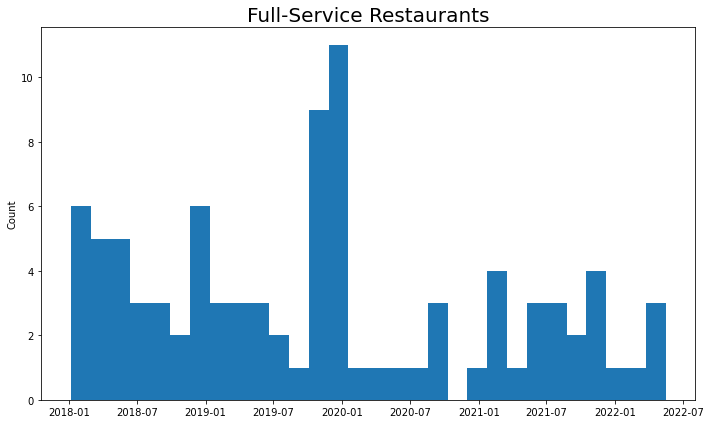

In [11]:
#collapse
plt.figure(figsize=(10,6))
restaurants = business.query('Industry == "Full-Service Restaurants "')
plt.hist(x=restaurants['IssueDate'],bins=30)
plt.title('Full-Service Restaurants',fontdict={'size':20})
plt.ylabel('Count')
plt.tight_layout()

It's clear that *Full-Service Restaurants* shows Covid-19 impact and has decreased in number begining the pandemic, which is in line with what we see in the news. 

Let's try a different way to better visualize Covid-19's impact on industries. We can compute changes in number of businesses in each industry after Covid-19 and plot them in order. Absolute number of businesses won't make sense here, because numbers of businesses in different sectors and industries vary, as shown in pie charts. We will use percentage change in number of business and only include industries that have more than 70 businesses. 

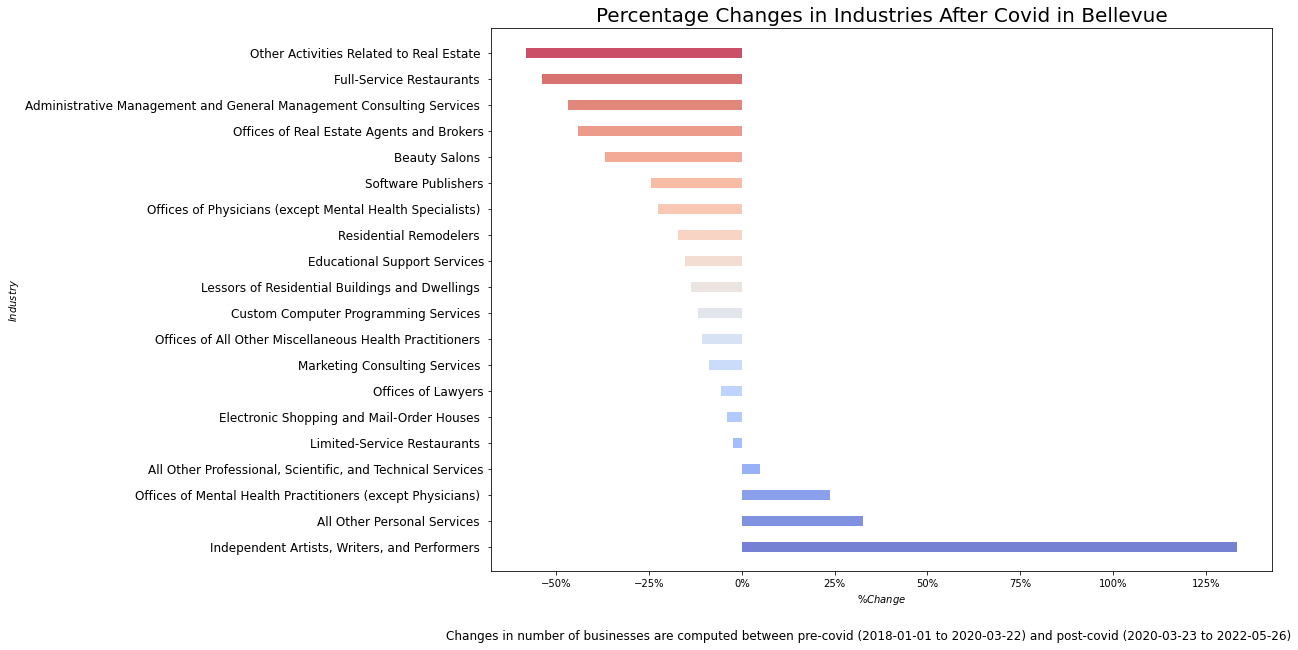

In [12]:
#collapse
industry_count = business['Industry'].value_counts()
industries = industry_count[industry_count>70].index
industries_group = business[business['Industry'].isin(industries)].groupby(['Industry','post_covid'],dropna=True).ObjectId.count()
industries_change = industries_group.pct_change()
post_covid = [idx[1] for idx in industries_group.index]
industries_change_post = industries_change[post_covid].sort_values(ascending=False)
industries_change_post = industries_change_post.reset_index()


plt.figure(figsize=(14,10))
plt.hlines(y=industries_change_post.index,xmin=0,xmax=industries_change_post.ObjectId,color=plt.cm.coolwarm(np.linspace(0,1,20)),
          alpha=0.7,linewidth=10)
plt.gca().set(ylabel='$Industry$', xlabel='$\\% Change$')
plt.yticks(industries_change_post.index,industries_change_post.Industry,fontsize=12)
plt.title('Percentage Changes in Industries After Covid in Bellevue',fontdict={'size':20})
txt="Changes in number of businesses are computed between pre-covid (2018-01-01 to 2020-03-22) and post-covid (2020-03-23 to 2022-05-26)"
plt.figtext(0.5, 0.03, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

This is a much better visualization. Both *Full-Service Restaurants* and *Other Activities Related to Real Estate* are down more than 50% after the pandemic. More interestingly, *Independent Artists, Writers, and Performers* jumps about 130%! This number is significant enough that we can conclude many people are starting their businesses as artist or writers in Bellevue. Next time if you see a small photography company in Bellevue, you won't be surprised. I also wonder if this phenomenon may has something to do with record high job openings recently. That would be another project.

## Conclusion
In order to show Covid-19 impact on businesses in Bellevue, we analyze and plot business listing dataset. The original dataset is not very useful for our objective, but we are able to extract sector and industry data from NAICS code, which turns out to be crucial to gain insights on how Covid-19 affect new businesses in Bellevue. Though we couldn't conclude that there are more small companies in residential area, the result shows *Independent Artists, Writers, and Performers* industry is booming. I can confidently tell my wife that many people in Bellevue are becoming artists and writers and starting their own businesses. I hope you learning something here. Thank you for reading!
